In [ ]:
import os
os.environ["KERAS_BACKEND"] = "jax"

In [52]:
import keras
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.integrate import odeint

import bayesflow as bf

In [38]:
np.set_printoptions(suppress=True)

# We don't worry about jax determinism, for now. Only Keras.
keras.utils.set_random_seed(2026)
rng = np.random.default_rng(2026)

In [ ]:
def prior(rng=None):
    if rng is None:
        rng = np.random.default_rng(seed=2026)

    x = rng.normal(size=4)
    # logit normal distribution scaled to range from 0.1 and 4
    theta = 1/(1+np.exp(-x)) * 3.9 + 0.1 
    return dict(
        alpha=theta[0],
        beta=theta[1],
        gamma=theta[2],
        delta=theta[3],
    )


def lotka_volterra_equations(state, t, alpha, beta, gamma, delta):
    x, y = state
    dxdt = alpha * x - beta * x * y
    dydt = - gamma * y + delta * x * y
    return [dxdt, dydt]


def ecology_model(alpha, beta, gamma, delta, t_span=[0, 5], t_steps=100, initial_state=[1, 1]):
    t = np.linspace(t_span[0], t_span[1], t_steps)
    state = odeint(lotka_volterra_equations, initial_state, t, args=(alpha, beta, gamma, delta))
    x, y = state.T
    
    return dict(
        x=x,  # Prey time series
        y=y,  # Predator time series
        t=t,  # Time vector
    )


def observation_model(x, y, t, subsample=10, obs_prob=1.0, noise_scale=0.1, rng=None):
    if rng is None:
        rng = np.random.default_rng(seed=2026)

    t_steps = x.shape[0]
    
    # Add Gaussian noise to observations
    noisy_x = rng.normal(x, noise_scale)
    noisy_y = rng.normal(y, noise_scale)
    
    # Determine which time steps are observed
    step_indices = np.arange(0, t_steps, subsample)
    num_observed = int(obs_prob * len(step_indices))
    observed_indices = np.sort(rng.choice(step_indices, num_observed, replace=False))

    return {
        "observed_x": noisy_x[observed_indices],
        "observed_y": noisy_y[observed_indices],
        "observed_t": t[observed_indices]
    }

In [ ]:
p = prior(rng=rng)
p

{'alpha': np.float64(1.3148445672500593),
 'beta': np.float64(2.2834322704027272),
 'gamma': np.float64(0.6090468149948529),
 'delta': np.float64(3.2258970550948094)}

In [43]:
observation_model(**ecology_model(**p))

{'observed_x': array([ 0.92068775,  0.36468529,  0.00414944, -0.10283889,  0.02665296,
         0.1658425 , -0.09510674, -0.1704324 ,  0.15727275,  0.06512292]),
 'observed_y': array([0.80427722, 2.01810223, 2.04022659, 1.27979983, 1.25896166,
        0.71103552, 0.66904544, 0.48421117, 0.44574751, 0.25777998]),
 'observed_t': array([0.        , 0.50505051, 1.01010101, 1.51515152, 2.02020202,
        2.52525253, 3.03030303, 3.53535354, 4.04040404, 4.54545455])}

In [47]:
simulator = bf.make_simulator(
    [prior, ecology_model, observation_model]
)

In [48]:
num_trajectories = 100
samples = simulator.sample(num_trajectories)
keras.tree.map_structure(keras.ops.shape, samples)

{'alpha': (100, 1),
 'beta': (100, 1),
 'gamma': (100, 1),
 'delta': (100, 1),
 'x': (100, 100),
 'y': (100, 100),
 't': (100, 100),
 'observed_x': (100, 10),
 'observed_y': (100, 10),
 'observed_t': (100, 10)}

In [55]:
samples["alpha"]

array([[1.31484457],
       [1.31484457],
       [1.31484457],
       [1.31484457],
       [1.31484457],
       [1.31484457],
       [1.31484457],
       [1.31484457],
       [1.31484457],
       [1.31484457],
       [1.31484457],
       [1.31484457],
       [1.31484457],
       [1.31484457],
       [1.31484457],
       [1.31484457],
       [1.31484457],
       [1.31484457],
       [1.31484457],
       [1.31484457],
       [1.31484457],
       [1.31484457],
       [1.31484457],
       [1.31484457],
       [1.31484457],
       [1.31484457],
       [1.31484457],
       [1.31484457],
       [1.31484457],
       [1.31484457],
       [1.31484457],
       [1.31484457],
       [1.31484457],
       [1.31484457],
       [1.31484457],
       [1.31484457],
       [1.31484457],
       [1.31484457],
       [1.31484457],
       [1.31484457],
       [1.31484457],
       [1.31484457],
       [1.31484457],
       [1.31484457],
       [1.31484457],
       [1.31484457],
       [1.31484457],
       [1.314

In [53]:
def trajectory_aggregation(traj, confidence=0.95):
    alpha = 1 - confidence
    quantiles = np.quantile(traj, [alpha/2, 0.5, 1-alpha/2], axis=0).T
    central = quantiles[:,1]
    L = quantiles[:,0]
    U = quantiles[:,2]
    return central, L, U

def plot_trajectores(samples, variable_keys, variable_names, fill_colors=["blue", "darkred"], confidence=0.95, alpha=0.8, observations=None, ax=None):
    t_span = samples["t"][0]
    
    if ax is None:
        fig, ax = plt.subplots(1, figsize=(12,3))
        sns.despine()
    
    for i, key in enumerate(variable_keys):

        if observations is not None:     
            ax.scatter(observations["observed_t"], observations["observed_"+key], color=fill_colors[i], marker="x", label="Observed " + variable_names[i].lower())

        central, L, U = trajectory_aggregation(samples[key], confidence=confidence)
        ax.plot(t_span, central, color=fill_colors[i], label="Median " + variable_names[i].lower())
        ax.fill_between(t_span, L, U, color=fill_colors[i], alpha=0.2, label=rf"{int((confidence) * 100)}$\%$ Confidence Bands")

        # plot 20 trajectory samples
        for j in range(20):
            if j == 0:
                label = f"{variable_names[i]} trajectories"
            else:
                label = None
            ax.plot(t_span, samples[key][j], color=fill_colors[i], alpha=0.2, label=label)
        

    ax.legend()
    ax.set_xlabel("t")
    ax.set_ylabel("population")

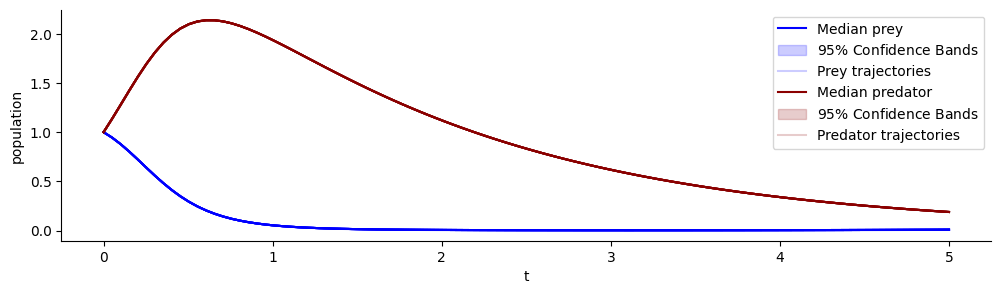

In [54]:
plot_trajectores(samples, ["x", "y"], ["Prey", "Predator"])